# Multi-Class Classification with Perceptron

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import random

You can use the following perceptron training code from the lecture:

In [6]:
def train(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # initialize weights
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 10
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

In [13]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

1.0

### Reading the Dataset

This code download the dataset from the repository on the internet. You can also manually copy the dataset from `/data` directory of AI Curriculum repo.

In [3]:
!rm -f *.pkl *.gz  
!wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz -O mnist.pkl.gz
!gzip -d mnist.pkl.gz


zsh:1: no matches found: *.pkl
--2024-03-23 17:06:29--  https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz
Auflösen des Hostnamens github.com (github.com)… 140.82.121.3
Verbindungsaufbau zu github.com (github.com)|140.82.121.3|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz [folgend]
--2024-03-23 17:06:29--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Auflösen des Hostnamens raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Verbindungsaufbau zu raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 17051982 (16M) [application/octet-stream]
Wird in »mnist.pkl.gz« gespeichert.

mnist.pkl.gz 

In [4]:
with open('mnist.pkl', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle, encoding='latin1')


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01171875 0.0703125
 0.0703125  0.0703125  0.4921875  0.53125    0.68359375 0.1015625
 0.6484375  0.99609375 0.96484375 0.49609375 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.1171875  0.140625
 0.3671875  0.6015625 ]
5


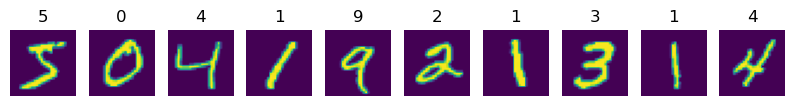

In [7]:
train_set, validation_set, test_set = MNIST
train_features, train_labels = train_set

print(train_features[0][130:180])
print(train_labels[0])

features = train_features.astype(np.float32) / 256.0
labels = train_labels

fig = plt.figure(figsize=(10, 5))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    plt.imshow(features[i].reshape(28, 28))
    ax.set_title(labels[i])
    plt.axis('off')
plt.show()


Code to create *one-vs-other* dataset for two-digit classification. You need to modify this code to create *one-vs-all* dateset.

In [23]:
def set_mnist_pos_neg(positive_label, negative_label):
    positive_indices = [i for i, j in enumerate(MNIST['Train']['Labels']) 
                          if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST['Train']['Labels']) 
                          if j == negative_label]

    positive_images = MNIST['Train']['Features'][positive_indices]
    negative_images = MNIST['Train']['Features'][negative_indices]

    return positive_images, negative_images

Now you need to:
1. Create 10 *one-vs-all* datasets for all digits
1. Train 10 perceptrons
1. Define `classify` function to perform digit classification
1. Measure the accuracy of classification and print *confusion matrix*
1. [Optional] Create improved `classify` function that performs the classification using one matrix multiplication.

In [8]:
# 1. Create 10 *one-vs-all* datasets for all digits

# modify dataset creation function for one-vs-all classification
# for this we have to rewrite the code so that it works with tuples instead of string keys (as per deffault) 
# because we had to lead the MNIST data differently due to lacking reproducibility of the original code
def set_mnist_pos_neg(positive_label):
    features, labels = train_set

    # allocate images and bias term and standardization
    positive_images = np.array([np.append(f, 1) for i, f in enumerate(features) if labels[i] == positive_label]) / 255.0
    negative_images = np.array([np.append(f, 1) for i, f in enumerate(features) if labels[i] != positive_label]) /255.0
    
    return positive_images, negative_images

train_set, validation_set, test_set = MNIST
train_features, train_labels = train_set

# Create datasets for all digits
datasets = {}
for i in range(10):
    pos, neg = set_mnist_pos_neg(i)
    datasets[i] = {'positive': pos, 'negative': neg}

print(datasets.keys())


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [20]:
# 2. train 10 perceptrons

#train function from above 
def train(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    
    # Initialize weights. 
    weights = np.zeros((num_dims, 1))  
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 10
    
    for i in range(num_iterations):
        # Pick one positive and one negative example
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        # Perform a dot product and update weights if necessary
        z = np.dot(pos, weights)
        if z < 0:  # Positive example was classified as negative
            weights += pos[:, np.newaxis]

        z = np.dot(neg, weights)
        if z >= 0:  # Negative example was classified as positive
            weights -= neg[:, np.newaxis]
            
        # Periodically report accuracy
        if i % report_frequency == 0:
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print(f"Iteration={i}, pos correct={pos_correct}, neg correct={neg_correct}")

    return weights


# train 

perceptrons = {}

for digit in range(10):
    print(f"Training perceptron for digit {digit}")
    
    pos_images = datasets[digit]['positive']
    neg_images = datasets[digit]['negative']
    
    weights = train(pos_images, neg_images, num_iterations=100)
    
    # Save the weights for this digit
    perceptrons[digit] = weights

Training perceptron for digit 0
Iteration=0, pos correct=0.0, neg correct=1.0
Iteration=10, pos correct=0.8440794809407948, neg correct=0.8129936984112897
Iteration=20, pos correct=0.9819545823195458, neg correct=0.7728987308067808
Iteration=30, pos correct=0.9268045417680454, neg correct=0.9465252507322268
Iteration=40, pos correct=0.9268045417680454, neg correct=0.9465252507322268
Iteration=50, pos correct=0.4943227899432279, neg correct=0.9970045264932991
Iteration=60, pos correct=0.9227493917274939, neg correct=0.9633886571403213
Iteration=70, pos correct=0.977088402270884, neg correct=0.9193219135528534
Iteration=80, pos correct=0.9600567721005677, neg correct=0.9536256323777403
Iteration=90, pos correct=0.9600567721005677, neg correct=0.9536256323777403
Training perceptron for digit 1
Iteration=0, pos correct=0.0, neg correct=1.0
Iteration=10, pos correct=0.9459316660796055, neg correct=0.9320202156942377
Iteration=20, pos correct=0.976224022543149, neg correct=0.94323360859167
I

In [12]:
# 3. Define `classify` function to perform digit classification
# including optional task 4: Create improved `classify` function 
# that performs the classification using one matrix multiplication.
def classify(image, perceptrons):
    outputs = []
    for digit, weights in perceptrons.items():
        z = np.dot(image, weights.flatten()) 
        outputs.append((digit, z))
    print(outputs)    

    # pred digit is the one with the higher value for z is outout vector
    predicted_digit = max(outputs, key=lambda x: x[1])[0]
    return predicted_digit


[(0, -0.0003687328405618195), (1, -0.0007628582680174431), (2, -0.0007296460885822908), (3, -0.0010172167114945677), (4, -0.0008098490033552698), (5, -0.0007999770787759587), (6, -0.0009319366844464714), (7, 0.0010498671205065016), (8, -0.0004976291884175361), (9, -0.0003509948621042473)]
[(0, -0.0002064882104177206), (1, 3.4774316080912796e-05), (2, 0.0012949571669175126), (3, -0.0008427819361967898), (4, -0.0017193049801675238), (5, -0.00013900293243331556), (6, 0.00041240851983074584), (7, -0.0022204679170088446), (8, -0.0006739790183838282), (9, -0.0012125803675965417)]
[(0, -0.0011988325672084715), (1, 0.00046648342052218165), (2, -0.0005320930478286616), (3, -0.0008505496686639698), (4, -0.0002008507214250532), (5, -0.0008424118777605381), (6, -0.0004274967159749305), (7, -0.0003244932595965436), (8, 9.657962704815045e-05), (9, -0.0002208700659978416)]
[(0, 0.0018234045317157385), (1, -0.0012121682975402216), (2, -0.0008237965134497368), (3, -0.0019357096890030114), (4, -0.001839

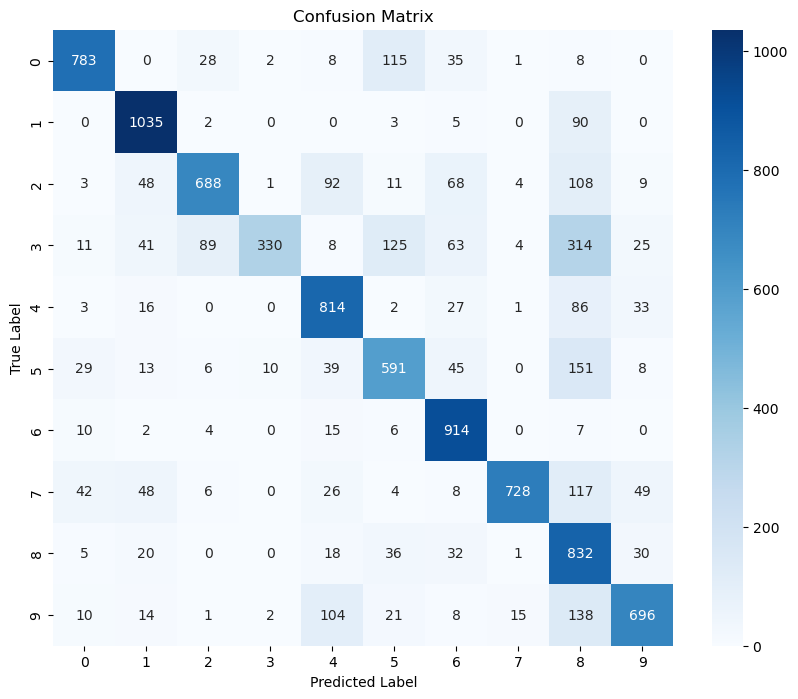

In [21]:
# 4. Measure the accuracy of classification and print *confusion matrix*
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate(test_features, test_labels, perceptrons):
    predictions = [classify(image, perceptrons) for image in test_features]
    
    #  accuracy
    accuracy = np.mean(np.array(predictions) == test_labels)
    print(f"Classification accuracy: {accuracy*100:.2f}%")
    
    # confusion matrix
    conf_matrix = confusion_matrix(test_labels, predictions)
    
    # plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    return conf_matrix


test_features, test_labels = test_set

test_features_with_bias = np.array([np.append(f, 1) for f in test_features.reshape(test_features.shape[0], -1)]).astype(np.float32) / 255.0

# Evaluate
conf_matrix = evaluate(test_features_with_bias, test_labels, perceptrons)
